In [47]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle
from sklearn import svm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, homogeneity_score, adjusted_mutual_info_score, completeness_score, adjusted_rand_score, v_measure_score
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib import pylab
import re
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [48]:
class1 = ['comp.graphics', 
                       'comp.os.ms-windows.misc', 
                       'comp.sys.ibm.pc.hardware', 
                       'comp.sys.mac.hardware']

class2 = [ 'rec.autos', 
                         'rec.motorcycles', 
                         'rec.sport.baseball', 
                         'rec.sport.hockey' ]

In [49]:
target_names = ['class1', 'class2']

In [50]:
c1_train_x = fetch_20newsgroups(subset='all', categories=class1, shuffle=True, random_state=42)
c2_train_x = fetch_20newsgroups(subset='all', categories=class2, shuffle=True, random_state=42)
comb_train_x = c1_train_x.data + c2_train_x.data

In [51]:
c1_train_y = [0] * len(c1_train_x.target)
c2_train_y = [1] * len(c2_train_x.target)

train_y = c1_train_y + c2_train_y

In [52]:
def preprocess_data(data):
        letters_only = re.sub("[^a-zA-Z]", " ", data)
        words = letters_only.split()
        words = [w.lower() for w in words if not w.lower() in stopwords.words('english')]
        return(" ".join( words ))

In [53]:
preproc_train_data = []

for data in comb_train_x:
	preproc_train_data.append((data))

<h3>Creating a TFxIDF vector representation of training and test data</h3><br> A CountVectorizer object is created to first build a vocabulary of words and their respective counts, and then transform the sentences by replacing the words with their respective counts. A TfIdfTransformer object is created and then fit on the training dataset to then extract TfIdf features from each document in both training and test datasets. 

In [54]:
#vectorizer = CountVectorizer(min_df = 3)
#tfidf_transformer = TfidfTransformer()
#vec_train_x = vectorizer.fit_transform(preproc_train_data)
#tfidf_train_x = tfidf_transformer.fit_transform(vec_train_x)

vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_train_x = vectorizer.fit_transform(preproc_train_data)

In [55]:
print('Dimensions of the TFIDF matrix are: ' + str(tfidf_train_x.shape))

Dimensions of the TFIDF matrix are: (7882, 27768)


In [56]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=10, random_state=35)
km.fit(tfidf_train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=35, tol=0.0001, verbose=0)

In [57]:
contingency_matrix(train_y, km.labels_)

array([[3899,    4],
       [2251, 1728]])

In [58]:
print("Homogeneity: %0.3f" % homogeneity_score(train_y, km.labels_))
print("Completeness: %0.3f" % completeness_score(train_y, km.labels_))
print("V-measure: %0.3f" % v_measure_score(train_y, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % adjusted_rand_score(train_y, km.labels_))
print("Adjusted Mutual Info: %.3f"
      % adjusted_mutual_info_score(train_y, km.labels_))

Homogeneity: 0.255
Completeness: 0.336
V-measure: 0.290
Adjusted Rand-Index: 0.183
Adjusted Mutual Info: 0.255


In [59]:
svd_model = TruncatedSVD(n_components=1000, random_state=0)
train_x2 = svd_model.fit_transform(tfidf_train_x)

In [70]:
r_values = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogeneity = []
completeness = []
v_mes = []
rand_ind = []
mutual_info = []

In [71]:
for r in r_values:
    km.fit(train_x2[:,:r])
    homogeneity.append(homogeneity_score(train_y, km.labels_))
    completeness.append(completeness_score(train_y, km.labels_))
    v_mes.append(v_measure_score(train_y, km.labels_))
    rand_ind.append(adjusted_rand_score(train_y, km.labels_))
    mutual_info.append(adjusted_mutual_info_score(train_y, km.labels_))

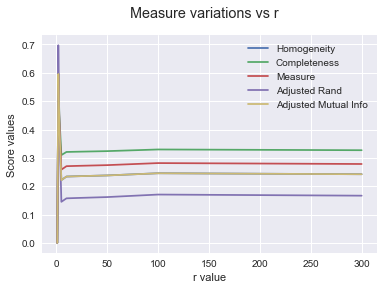

In [72]:
fig = plt.figure()

plt.plot(r_values, homogeneity, label='Homogeneity Values')
plt.plot(r_values, completeness, label='Completeness Values')
plt.plot(r_values, v_mes, label='V Measure Values')
plt.plot(r_values, rand_ind, label='Adjusted Rand Values')
plt.plot(r_values, mutual_info, label='Adjusted Mutual Info Values')

fig.suptitle('Measure variations vs r')
pylab.xlabel('r value')
pylab.ylabel('Score values')
plt.legend(['Homogeneity', 'Completeness', 'Measure', 'Adjusted Rand', 'Adjusted Mutual Info'], loc='upper right')
plt.show()

In [75]:
best_train = train_x2[:,:2]

In [76]:
km.fit(best_train)

print("Homogeneity: %0.3f" % homogeneity_score(train_y, km.labels_))
print("Completeness: %0.3f" % completeness_score(train_y, km.labels_))
print("V-measure: %0.3f" % v_measure_score(train_y, km.labels_))
print("Adjusted Rand-Index: %.3f"
% adjusted_rand_score(train_y, km.labels_))
print("Adjusted Mutual Info: %.3f"
% adjusted_mutual_info_score(train_y, km.labels_))

Homogeneity: 0.596
Completeness: 0.597
V-measure: 0.597
Adjusted Rand-Index: 0.697
Adjusted Mutual Info: 0.596


In [77]:
contingency_matrix(train_y, km.labels_)

array([[3699,  204],
       [ 446, 3533]])

In [78]:
y_kmeans = km.predict(best_train)

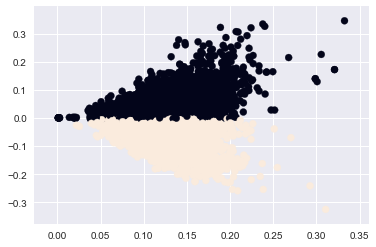

In [79]:
fig = plt.figure()

plt.scatter(train_x2[:,:2][:,0], train_x2[:,:2][:,1], c=y_kmeans)

plt.show()